# Fit an LSTM (Model 1) to Shasta Reservoir

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


## Data Processing

In [3]:
from src.data.data_processing import *
from src.data.data_fetching import *

In [4]:
# Read in data, columns are [inflow, outflow, storage]
df = usbr_fetch_data(name='Shasta', vars=['inflow', 'outflow', 'storage'])

In [5]:
# Add day of the year (doy) as another column
df['doy'] = df.index.to_series().dt.dayofyear

In [6]:
# Select data window (beginning of 1944 to end of 2022)
df = df['1944-01-01':'2022-12-31'].copy()

In [7]:
# Run data processing pipeline
pipeline = processing_pipeline(train_frac=0.6, val_frac=0.2, test_frac=0.2, chunk_size=3*365, pad_value=-1)
# train and val of shape (#chunks, chunksize, [inflow, outflow, storage, doy]), test of shape (timesteps, [inflow, outflow, storage, doy])
ts_train, ts_val, ts_test = pipeline.process_data(df) 

In [8]:
## Separate inputs(X) and targets (y)

# select inflow and doy as input features
X_train, X_val, X_test = ts_train[:, :, [0, 3]], ts_val[:, :, [0, 3]], ts_test[:, [0, 3]]
# select outflow as target feature
y_train, y_val, y_test = ts_train[:, :, [1]], ts_val[:, :, [1]], ts_test[:, [1]]

In [9]:
# Create PyTorch dataset and dataloader
dataset_train, dataset_val, dataset_test = TensorDataset(X_train, y_train), TensorDataset(X_val, y_val), TensorDataset(X_test, y_test)
dataloader_train, dataloader_val, dataloader_test = DataLoader(dataset_train), DataLoader(dataset_val), DataLoader(dataset_test)

## Tune Model 1 to Shasta data

In [10]:
from src.models.model_zoo import *
from src.models.predict_model import *
from src.models.train_model import *

In [109]:
# instantiate model
input_size = 2
hidden_size1 = 35
hidden_size2 = 35
output_size = 1
dropout_prob = 0
num_layers = 2

torch.manual_seed(0)
model1_tune = LSTMModel1_opt(input_size=input_size, hidden_size1=hidden_size1, 
                             hidden_size2=hidden_size2, output_size=output_size, num_layers=num_layers, dropout_prob=dropout_prob)
criterion = nn.MSELoss()
optimizer = optim.Adam(model1_tune.parameters(), lr=0.001)

In [110]:
# run training loop and get validation error
train_losses, val_losses = training_loop(model=model1_tune, criterion=criterion, optimizer=optimizer, 
                                         patience=10, dataloader_train=dataloader_train, dataloader_val=dataloader_val, epochs=200)

Training epochs:  36%|███▌      | 71/200 [00:22<00:40,  3.18it/s]


In [108]:
final_error(val_losses)

Final validation loss: 0.344790648513784, Epochs trained: 77


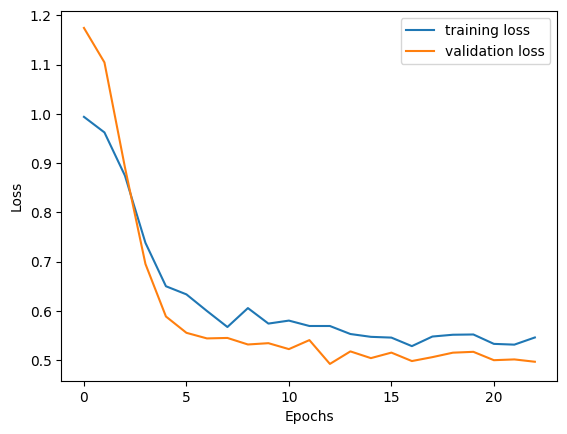

In [102]:
plot_train_val(train_losses, val_losses)